In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

import pathlib
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\gurus\anaconda3\envs\Learning_DS_ML_DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    print('Num devices = ', torch.cuda.device_count())
    print('Device Name = ', torch.cuda.get_device_name(0))

Num devices =  1
Device Name =  NVIDIA GeForce RTX 2060 with Max-Q Design


In [3]:
class ImageDataset_for_birds(Dataset):

    def __init__(self, file_list_df, num_classes, transform=None):

        self.file_list_df = file_list_df
        self.transform = transform
        self.num_classes = num_classes

    def __getitem__(self, index):

        img = Image.open('Birds_dataset/' + self.file_list_df['filepaths'][index])

        if self.transform is not None:
            img = self.transform(img)

        label = self.file_list_df['class id'][index]
        label = F.one_hot( torch.tensor(label) , self.num_classes )

        return img, label

    def __len__(self):

        return len(self.file_list_df)

In [4]:
class CNN(nn.Module):

    def __init__(self, in_ch, out_num_classes):
        super().__init__()

        self.layers = [
                nn.Conv2d(in_channels=in_ch, out_channels=12, kernel_size=(11,11), stride=1, padding='same'),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(5,5), stride=1, padding='same'),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=0.2),
                nn.BatchNorm2d(12),

                nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(5,5), stride=1, padding='same'),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(12),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(3,3), stride=1, padding='same'),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(10),
                nn.Dropout2d(p=0.3),
                nn.MaxPool2d(kernel_size=2, stride=2),
            
                nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=1, padding='same'),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(10),
                nn.MaxPool2d(kernel_size=2, stride=2),
            
                nn.Flatten(start_dim=1),
                nn.Linear(in_features = 6250, out_features=1000),
                nn.ReLU(inplace=True),
                nn.Linear(in_features=1000, out_features=out_num_classes),

                #nn.Softmax(dim=1),
                #nn.Sigmoid()
                ]

        self.model = nn.Sequential(*self.layers)


    def forward(self, x):
        return self.model(x)


In [5]:
dataset_files_list_file_path = 'Birds_dataset/birds.csv'

master_file_df = pd.read_csv(dataset_files_list_file_path)
print('CSV file memory usage ---\n', master_file_df.memory_usage(),'\n\n\n')

train_files_df = master_file_df[master_file_df['data set'] == 'train'].filter(items=['class id','filepaths'])

#Shuffle the train dataset file list
train_files_df = train_files_df.sample(frac=1)

print(train_files_df)


CSV file memory usage ---
 Index                  128
class id            601008
filepaths           601008
labels              601008
scientific label    601008
data set            601008
dtype: int64 



       class id                             filepaths
33985       217  train/GOLDEN CHEEKED WARBLER/146.jpg
54607       348        train/PURPLE GALLINULE/108.jpg
26332       167      train/DARWINS FLYCATCHER/093.jpg
8312         53        train/BAND TAILED GUAN/031.jpg
16610       106       train/CALIFORNIA CONDOR/028.jpg
...         ...                                   ...
14926        95        train/BRANDT CORMARANT/141.jpg
54434       347            train/PURPLE FINCH/088.jpg
6716         42        train/AZARAS SPINETAIL/081.jpg
24530       156            train/CRIMSON CHAT/134.jpg
6274         39       train/AUSTRAL CANASTERO/147.jpg

[70626 rows x 2 columns]


In [6]:
#Validation Dataset
master_file_df.reset_index(inplace=True)
validation_files_df = master_file_df[master_file_df['data set'] == 'valid'].filter(items=['class id','filepaths'])

#Shuffle the train dataset file list
validation_files_df = validation_files_df.sample(frac=1)

validation_files_df.reset_index(inplace=True)
print(validation_files_df)

      index  class id                              filepaths
0     74435       311           valid/MIKADO  PHEASANT/5.jpg
1     73367        98                valid/BROWN NOODY/2.jpg
2     73294        83  valid/BLONDE CRESTED WOODPECKER/4.jpg
3     74441       313                       valid/MYNA/1.jpg
4     73066        38              valid/AUCKLAND SHAQ/1.jpg
...     ...       ...                                    ...
2245  74718       368        valid/RED WISKERED BULBUL/3.jpg
2246  74828       390     valid/SHORT BILLED DOWITCHER/3.jpg
2247  73640       152         valid/CRESTED KINGFISHER/5.jpg
2248  74920       408           valid/STRIPPED SWALLOW/5.jpg
2249  73592       143            valid/COMMON STARLING/2.jpg

[2250 rows x 3 columns]


In [7]:
print(train_files_df['filepaths'][1000])
print(train_files_df['class id'][1000])
num_train_samples = len(train_files_df)
print(num_train_samples)

num_validation_samples = len(validation_files_df)
print(num_validation_samples)

train/AFRICAN OYSTER CATCHER/048.jpg
6
70626
2250


In [8]:
#Count the number of output class in the dataset
n_classes = train_files_df['class id'].nunique()

print(n_classes)

450


In [9]:
# Create train dataset
img_height, img_width = 200,200

#Image Transform
transformX = transforms.Compose( [
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width)),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5], inplace=True), # Set the pixel values in -1,1 range
    ] )

train_dataset = ImageDataset_for_birds(train_files_df, n_classes, transformX)

In [10]:
# Create Validation Dataset
validation_dataset = ImageDataset_for_birds(validation_files_df, n_classes, transformX)

In [11]:
# Create DataLoader
from torch.utils.data import DataLoader
train_data_loader = DataLoader(train_dataset, batch_size=250, drop_last=False, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=20, drop_last=False, shuffle=False)

torch.Size([3, 200, 200])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 0.9368,  0.9285,  0.9220,  ..., -0.1045, -0.0333,  0.0482],
         [ 0.9373,  0.9361,  0.9308,  ..., -0.0760,  0.0021,  0.0805],
         [ 0.9373,  0.9377,  0.9396,  ..., -0.0400,  0.0502,  0.1434],
         ...,
         [ 0.3567,  0.3960,  0.4173,  ...,  0.4525,  0.4307,  0.4002],
         [ 0.3656,  0.4067,  0.4260,  ...,  0.4438,  0.4238,  0.3915],
         [ 0.3744,  0.4155,  0.4326,  ...,  0.4424,  0.4164,  0.3827]],

        [[ 0.9447,  0.9363,  0.9299,  ...,  0.0259,  0.0794,  0.1580],
         [ 0.9451,  0.9439,  0.9387,  ...,  0.0544,  0.1154,  0.1889],
         [ 0.9451,  0.9455,  0.9475,  ...,  0.0785,  0.1585,  0.2457],
         ...,
         [ 0.4901,  0.5308,  0.5584,  ...,  0.5310,  0.5091,  0.4933],
         [ 0.4990,  0.5415,  0.5672,  ...,  0.5222,  0.5023,  0.4847],
         [ 0.5078,  0.5503,  0.5738,  ...,  0.5208,  0.4948,  0.4759]],

        [[ 0.9839,  0.9741,  0.9613,  ...,  0.1243,  0.1682,  0.2443],
         [ 0.9843,  0.9817,  0.9700,  ...,  0

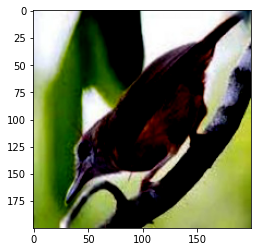

In [12]:
# Accessing the image and class
print(train_dataset[12][0].shape) #12th image
print(train_dataset[789][1]) #789th image class

# Display image
plt.imshow(train_dataset[95][0].permute(1, 2, 0)) #34th image
print(train_dataset[95][0])

In [13]:
# DEBUG 
# For better unterstanding only
num_epoch = 1

for epoch in range(num_epoch):
    for i,batch in enumerate(train_data_loader):
        print(batch[0].shape)
        print(batch[1].shape)
        print(batch[1])
        break



torch.Size([250, 3, 200, 200])
torch.Size([250, 450])
tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [14]:
# Create the CNN Model
bird_model = CNN(3,n_classes)


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
bird_model.apply(weights_init)

if torch.cuda.is_available():
    print('Model in GPU')
    bird_model = bird_model.to('cuda')

Model in GPU


In [15]:
# Get ready for training
num_epoch = 50
optimizer = torch.optim.Adam(bird_model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(bird_model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train_model = True

In [16]:
# Train Loops
if train_model:

    lowest_loss = 9999
    for epoch in (range(num_epoch)):
        print('Epoch ', epoch,'  --------------------')

        # Training -------------------------------------------------------------------------------------------
        bird_model.train()
        is_correct = 0
        for i,batch in enumerate(train_data_loader):

            image_batch = batch[0]
            class_batch = batch[1].to(torch.float64)

            if torch.cuda.is_available():
                image_batch = image_batch.to('cuda')
                class_batch = class_batch.to('cuda')

            optimizer.zero_grad()

            pred = bird_model(image_batch)
            loss = loss_fn(pred, class_batch)

            loss.backward()
            optimizer.step()
            
            is_correct += ( torch.argmax(pred, dim=1) == torch.argmax(class_batch, dim=1) ).sum()
            
            if i%10 == 0:
                #print(pred)
                if loss.item() < lowest_loss:
                    lowest_loss = loss.item()
                    print('---- Train Batch loss = ', loss.item(), 'Batch Correct = ', is_correct.item())
                else:
                    print('Train Batch loss = ', loss.item(), 'Batch Correct = ', is_correct.item())

        torch.save(bird_model.state_dict(), './saved_models/bird_model_' + str(epoch))

        train_acc = 100*(is_correct / num_train_samples)
        print('Train Acc = ',  train_acc)
        
        # Validation -------------------------------------------------------------------------------------------
        PATH = './saved_models/bird_model_' + str(epoch)
        val_model = CNN(3,n_classes)
        val_model.load_state_dict(torch.load(PATH))
        val_model.eval()

        is_correct = 0
        for i,batch in enumerate(validation_data_loader):

            image_batch = batch[0]
            class_batch = batch[1].to(torch.float64)

            pred = val_model(image_batch)

            is_correct += ( torch.argmax(pred, dim=1) == torch.argmax(class_batch, dim=1) ).sum()
            
        val_acc = 100*(is_correct / num_validation_samples)
        print('Val Acc = ',  val_acc)

        



Epoch  0   --------------------
---- Train Batch loss =  6.108828525543213 Batch Correct =  0
---- Train Batch loss =  6.108618782043457 Batch Correct =  7
---- Train Batch loss =  6.065981624603271 Batch Correct =  15
---- Train Batch loss =  5.930106908321381 Batch Correct =  25
---- Train Batch loss =  5.8510700130462645 Batch Correct =  45
---- Train Batch loss =  5.722415979385376 Batch Correct =  78
---- Train Batch loss =  5.692025235176087 Batch Correct =  118
---- Train Batch loss =  5.566217658936978 Batch Correct =  179
---- Train Batch loss =  5.439056052207947 Batch Correct =  250
---- Train Batch loss =  5.3517269921302795 Batch Correct =  325
---- Train Batch loss =  5.226999240875244 Batch Correct =  408
Train Batch loss =  5.384471148729324 Batch Correct =  498
Train Batch loss =  5.328637434631586 Batch Correct =  604
Train Batch loss =  5.361096869230271 Batch Correct =  731
---- Train Batch loss =  5.063906643390656 Batch Correct =  880
Train Batch loss =  5.1344920

Train Batch loss =  1.187143331644597 Batch Correct =  16617
Train Batch loss =  1.139223862559652 Batch Correct =  18438
Train Batch loss =  1.0946596980096506 Batch Correct =  20253
Train Batch loss =  1.1002733585272644 Batch Correct =  22058
Train Batch loss =  1.218637762717519 Batch Correct =  23854
Train Batch loss =  1.182929072579291 Batch Correct =  25620
Train Batch loss =  1.1443638714853228 Batch Correct =  27400
Train Batch loss =  1.226059780277245 Batch Correct =  29191
Train Batch loss =  1.179971867790085 Batch Correct =  30958
Train Batch loss =  1.186234781823633 Batch Correct =  32731
Train Batch loss =  1.4508728315684538 Batch Correct =  34464
Train Batch loss =  1.2809816012261728 Batch Correct =  36191
Train Batch loss =  1.266449472731921 Batch Correct =  37965
Train Batch loss =  1.3219937992582693 Batch Correct =  39736
Train Batch loss =  1.315578803938622 Batch Correct =  41475
Train Batch loss =  1.1265735986093242 Batch Correct =  43212
Train Batch loss 

KeyboardInterrupt: 

In [ ]:
for saved_model_idx in range(2,42):
    PATH = './saved_models/bird_model_' + str(saved_model_idx)
    test_model = CNN(3,n_classes)
    test_model.load_state_dict(torch.load(PATH))
    test_model.eval()

    is_correct = 0A
    for i,batch in enumerate(validation_data_loader):

        image_batch = batch[0]
        class_batch = batch[1].to(torch.float64)

        pred = test_model(image_batch)

        is_correct += ( torch.argmax(pred, dim=1) == torch.argmax(class_batch, dim=1) ).sum()

    validation_acc = is_correct / num_validation_samples
    print(str(saved_model_idx) + '  validation_acc = ', validation_acc)